# 基于邻域图的形状描述符
此笔记本演示了在无法精确分割细胞但可以检测到其中心的情况下，如何确定细胞的形状描述符。

In [1]:
from skimage.measure import regionprops
import numpy as np
import pyclesperanto_prototype as cle

cle.get_device()

<gfx90c on Platform: AMD Accelerated Parallel Processing (2 refs)>

我们生成一个具有给定 x 和 y 尺寸的细胞标签图像，比例为1:1.5。

假设这是某个细胞分割算法的结果。

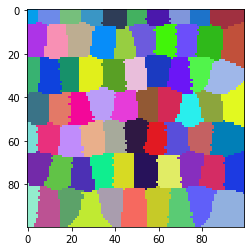

In [2]:
cell_size_x = 10
cell_size_y = 15

# generate and show tissue
tissue_labels = cle.artificial_tissue_2d(width=100, height=100, delta_x=cell_size_x, delta_y=cell_size_y, random_sigma_x=1, random_sigma_y=1)
cle.imshow(tissue_labels, labels=True)

# 经典形状描述符：短轴和长轴
我们可以使用 scikit-image 测量这些细胞的短轴和长轴

In [3]:
label_image = cle.pull_zyx(tissue_labels).astype(int)

stats = regionprops(label_image)

avg_minor_axis_length = np.mean([s.minor_axis_length for s in stats])
print("平均短轴长度", avg_minor_axis_length)

avg_major_axis_length = np.mean([s.major_axis_length for s in stats])
print("平均长轴长度", avg_major_axis_length)

Average minor axis length 11.094738115993875
Average major axis length 16.966309163176998


现在我们生成一个可能难以从中分割细胞的图像，例如膜图像。

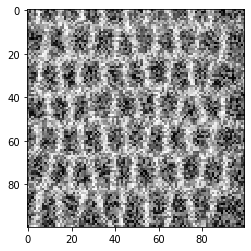

In [4]:
cell_borders = cle.detect_label_edges(label_image)

convolved_membranes = cle.gaussian_blur(cell_borders, sigma_x=1, sigma_y=2)

noise_level = 3
noise = (np.random.random(convolved_membranes.shape) - 0.5) * cle.mean_of_all_pixels(convolved_membranes) * noise_level
noise = noise.astype(np.float32)

artifical_membrane_image = (convolved_membranes + noise)

cle.imshow(artifical_membrane_image)

## 基于邻居网格的形状描述符
在某些情况下，我们无法正确分割细胞，我们只能进行斑点检测并可视化细胞的中心。

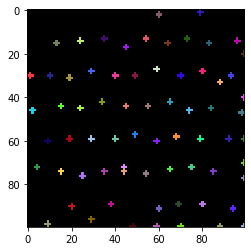

In [5]:
blurred = cle.gaussian_blur(artifical_membrane_image, sigma_x=2, sigma_y=2)

local_minima = cle.detect_minima_box(blurred)

spot_image = cle.label_spots(local_minima)

# 为了可视化目的，我们稍微扩展了斑点
spot_image = cle.maximum_sphere(spot_image, radius_x=1, radius_y=1)

cle.imshow(spot_image, labels=True)

从这样一个标记斑点的图像中，我们可以制作一个 Voronoi 图，我们可以分析哪些细胞（扩展的斑点）彼此靠近。

结果是细胞分割的近似。

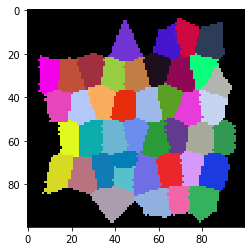

In [6]:
voronoi_diagram_all = cle.extend_labeling_via_voronoi(spot_image)

# 排除图像边缘的标签
voronoi_diagram = cle.exclude_labels_on_edges(voronoi_diagram_all)

cle.imshow(voronoi_diagram, labels=True)

从这样一对斑点图像和 Voronoi 图中，我们可以确定两个矩阵，一个接触矩阵（也称为邻接图矩阵）和一个距离矩阵。

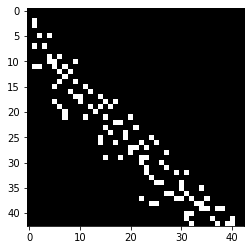

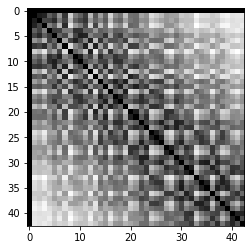

In [7]:
touch_matrix = cle.generate_touch_matrix(voronoi_diagram)

# 忽略与背景的接触
cle.set_column(touch_matrix, 0, 0)


centroids = cle.centroids_of_labels(voronoi_diagram)

distance_matrix = cle.generate_distance_matrix(centroids, centroids)


cle.imshow(touch_matrix)
cle.imshow(distance_matrix)

从这两个矩阵中，我们可以确定 Voronoi 图像中接触对象（细胞）质心之间的最小和最大距离。这些是分割对象的估计短轴和长轴。

In [8]:
min_distance = cle.minimum_distance_of_touching_neighbors(distance_matrix, touch_matrix)
max_distance = cle.maximum_distance_of_touching_neighbors(distance_matrix, touch_matrix)

print("接触邻居的最小距离", cle.mean_of_all_pixels(min_distance))
print("接触邻居的最大距离", cle.mean_of_all_pixels(max_distance))

minimum distance of touching neihbors 10.007136855014535
maximum distance of touching neihbors 16.39732325354288


## 距离可视化
最后，让我们在彩色网格中可视化邻居之间的距离。

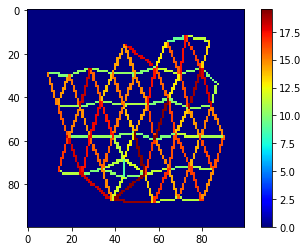

In [9]:
mesh = cle.draw_distance_mesh_between_touching_labels(voronoi_diagram)
cle.imshow(mesh, colorbar=True, colormap="jet")